### Installation & Import

In [24]:
import os
import random
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, Lipinski
from rdkit import DataStructs

from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader

from pl_bolts.optimizers.lr_scheduler import LinearWarmupCosineAnnealingLR

In [2]:
CFG = {
    'NBITS': 2048,
    'SEED': 42
}

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(CFG['SEED'])

# SMILES 데이터를 분자 지문으로 변환
def smiles_to_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=CFG['NBITS'])
        return np.array(fp)
    else:
        return np.zeros((CFG['NBITS'],))

In [3]:
def IC50_to_pIC50(ic50_nM):
    ic50_nM = np.clip(ic50_nM, 1e-10, None)
    return 9 - np.log10(ic50_nM)

In [4]:
def pIC50_to_IC50(pIC50):
    return 10 ** (9 - pIC50)

### Data loading & Molecular Descriptor

In [5]:
IC50_dataset = pd.read_csv("C:/Users/user/Desktop/dacon_drug_development/IC50_dataset.csv")
IC50_dataset['Fingerprint'] = IC50_dataset['smiles'].apply(smiles_to_fingerprint)

[14:29:37] DEPRECATION WARNING: please use MorganGenerator
[14:29:37] DEPRECATION WARNING: please use MorganGenerator
[14:29:37] DEPRECATION WARNING: please use MorganGenerator
[14:29:37] DEPRECATION WARNING: please use MorganGenerator
[14:29:37] DEPRECATION WARNING: please use MorganGenerator
[14:29:37] DEPRECATION WARNING: please use MorganGenerator
[14:29:37] DEPRECATION WARNING: please use MorganGenerator
[14:29:37] DEPRECATION WARNING: please use MorganGenerator
[14:29:37] DEPRECATION WARNING: please use MorganGenerator
[14:29:37] DEPRECATION WARNING: please use MorganGenerator
[14:29:37] DEPRECATION WARNING: please use MorganGenerator
[14:29:37] DEPRECATION WARNING: please use MorganGenerator
[14:29:37] DEPRECATION WARNING: please use MorganGenerator
[14:29:37] DEPRECATION WARNING: please use MorganGenerator
[14:29:37] DEPRECATION WARNING: please use MorganGenerator
[14:29:37] DEPRECATION WARNING: please use MorganGenerator
[14:29:37] DEPRECATION WARNING: please use MorganGenerat

In [6]:
def descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    f = {}
    # 1. 화학기 존재 여부
    # Tetrazole ring
    tetrazole_smarts = ['c1nn[n+](n1)[O-]', 'c1[nH]nnn1']
    f['has_tetrazole'] = any(mol.HasSubstructMatch(Chem.MolFromSmarts(s)) for s in tetrazole_smarts)
    # Triazole ring
    f['has_triazole'] = mol.HasSubstructMatch(Chem.MolFromSmarts('c1nnc(n1)'))
    # Sulfoxide group
    f['has_sulfoxide'] = mol.HasSubstructMatch(Chem.MolFromSmarts('S(=O)(C)'))
    # Amide carbonyl
    amide_smarts = ['C(=O)N', 'NC(=O)']
    f['has_amide'] = any(mol.HasSubstructMatch(Chem.MolFromSmarts(s)) for s in amide_smarts)
    # Sulfonamide group
    f['has_sulfonamide'] = mol.HasSubstructMatch(Chem.MolFromSmarts('S(=O)(=O)N'))
    
    # 2. 분자량
    mw = Descriptors.MolWt(mol)
    f['mw'] = mw
    f['mw_300_500'] = 300<=mw<=500
    
    # 3. logP
    logp = Descriptors.MolLogP(mol)
    f['logP'] = logp
    f['logP_2_4'] = 2<=logp<=4
    
    # 4. TPSA
    tpsa = Descriptors.TPSA(mol)
    f['TPSA'] = tpsa
    f['TPSA_60_120'] = 60<=tpsa<=120
    
    # 5. rotatable bonds (IC50 값 높임_bad)
    rot = Lipinski.NumRotatableBonds(mol)
    f['rotatable'] = rot
    f['rot_gt7'] = rot>7

    # 6. ring (+aromatic)
    # ring 2개 이상
    num_rings = mol.GetRingInfo().NumRings()
    f['num_rings'] = num_rings
    f['ring_count_ge_2'] = num_rings >= 2
    # aromatic ring 존재 여부
    ssr = Chem.GetSymmSSSR(mol)
    aromatic_ring = any(all(mol.GetAtomWithIdx(idx).GetIsAromatic() for idx in ring) for ring in ssr)
    f['has_aromatic_ring'] = aromatic_ring
    # Ring 2개 이상 + 그 중 적어도 하나 aromatic인가?
    f['ring_ge2_and_aromatic'] = f['ring_count_ge_2'] and f['has_aromatic_ring']

    return f

In [7]:
features_df = pd.DataFrame([descriptors(s) for s in IC50_dataset['smiles']])
final_dataset = pd.concat([IC50_dataset, features_df], axis=1)

### Custom Dataset

In [14]:
class CustomDataset(Dataset):
    def __init__(self, df, target, transform=None, is_test=False):
        """
        df          : DataFrame (train/valid/test)
        target  : 예측할 타겟 컬럼 이름 (예: 'IC50_nM' 또는 'pIC50')
        transform   : Feature selection / scaling 객체 (fit_transform, transform 지원)
        is_test     : 테스트셋 여부
        """
        self.df = df.reset_index(drop=True)
        self.target = target
        self.is_test = is_test
        self.transform = transform

        # Fingerprint 부분
        fp_array = np.stack(df['Fingerprint']).astype(np.float32)  # shape: (n_samples, fp_dim)

        # 기타 수치형 feature (Fingerprint 제외, target 제외, smiles 제외)
        feature_cols = [col for col in df.columns 
                        if col not in [target, 'Fingerprint']]
        feature_df = df[feature_cols].copy()

        # bool 컬럼을 int로 변환
        for c in feature_df.columns:
            if feature_df[c].dtype == 'bool':
                feature_df[c] = feature_df[c].astype(int)
        feature_array = feature_df.values.astype(np.float32)

        # Fingerprint + 나머지 feature 합치기
        X = np.hstack([fp_array, feature_array])  # shape: (n_samples, total_features)

        # transform 적용
        if self.transform:
            if not self.is_test:
                self.X = self.transform.fit_transform(X)
            else:
                self.X = self.transform.transform(X)
        else:
            self.X = X

        # Target 값 (test셋이면 없음)
        if not self.is_test:
            self.y = df[target].values

    def __getitem__(self, index):
        features = torch.tensor(self.X[index]).float()
        if not self.is_test:
            target = torch.tensor(self.y[index]).float().unsqueeze(-1)
            return features, target
        else:
            return features

    def __len__(self):
        return len(self.df)

In [15]:
transform = VarianceThreshold(threshold=0.05)

train = final_dataset.drop(['smiles', 'IC50_nM'], axis=1)
train_fpfv = CustomDataset(df=train, target='pIC50', transform=transform, is_test=False)

input_size = train_fpfv.X.shape[1]   # 205

In [16]:
# Hyperparameter
CFG_model = {
    'BATCH_SIZE': 512,
    'EPOCHS': 100,
    'INPUT_SIZE': input_size,
    'HIDDEN_SIZE': 1024,
    'OUTPUT_SIZE': 1,
    'DROPOUT_RATE': 0.2,
    'LEARNING_RATE': 0.0007
}

In [17]:
# train,valid split
train_dataset, valid_dataset = train_test_split(train_fpfv, test_size=0.3, random_state=42)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=CFG_model['BATCH_SIZE'], shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=CFG_model['BATCH_SIZE'], shuffle=False)

### Building MLP model

In [18]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate, out_size):
        super(Net, self).__init__()
        
        # fc 레이어 3개와 출력 레이어
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc_out = nn.Linear(hidden_size, out_size)
        
        # 정규화
        self.ln1 = nn.LayerNorm(hidden_size)
        self.ln2 = nn.LayerNorm(hidden_size)
        self.ln3 = nn.LayerNorm(hidden_size)        
        
        # 활성화 함수
        self.activation = nn.LeakyReLU()
        
        # Dropout
        self.dropout = nn.Dropout(dropout_rate)
     
    def forward(self, x):
        out = self.fc1(x)
        out = self.ln1(out)
        out = self.activation(out)
        out = self.dropout(out)
        
        out = self.fc2(out)
        out = self.ln2(out)
        out = self.activation(out)
        out = self.dropout(out)
        
        out = self.fc3(out)
        out = self.ln3(out)
        out = self.activation(out)
        out = self.dropout(out)

        out = self.fc_out(out)
        return out

In [19]:
model = Net(CFG_model['INPUT_SIZE'],CFG_model['HIDDEN_SIZE'],CFG_model['DROPOUT_RATE'],CFG_model['OUTPUT_SIZE'])

In [20]:
# CFG_model hyperparameters 추가
num_samples = len(train_dataset)
batch_size = CFG_model['BATCH_SIZE']
num_epochs = CFG_model['EPOCHS']

# step 단위 변수 대신 epoch 단위로 변환
warmup_epochs = int(num_epochs * 0.05)  # 5% warmup epochs

# CFG_model에 epoch 단위 key 파라미터 추가/업데이트
CFG_model['WARMUP_EPOCHS'] = warmup_epochs
CFG_model['MAX_EPOCHS'] = num_epochs

In [22]:
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=CFG_model['LEARNING_RATE'], weight_decay=1e-5)
scheduler = LinearWarmupCosineAnnealingLR(
    optimizer,
    warmup_epochs=CFG_model['WARMUP_EPOCHS'],
    max_epochs=CFG_model['MAX_EPOCHS'],
    eta_min=1e-5
)

C:\Users\user\AppData\Local\Temp\ipykernel_2412\1711788273.py:3: UnderReviewWarning: The feature LinearWarmupCosineAnnealingLR is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  scheduler = LinearWarmupCosineAnnealingLR(


### Train

In [23]:
def train(train_loader, valid_loader, model, criterion, optimizer, scheduler, epochs):
    train_loss = []
    valid_loss = []
    lrs = []

    for epoch in range(epochs):

        # Training
        model.train()
        running_loss = 0

        for inputs, targets in train_loader:
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        avg_train_loss = running_loss / len(train_loader)
        train_loss.append(avg_train_loss)

        # Validatation
        model.eval()
        valid_running_loss = 0
            
        with torch.no_grad():
            for inputs, targets in valid_loader:
                output = model(inputs)
                loss = criterion(output, targets)
                valid_running_loss += loss.item()
            
        avg_valid_loss = valid_running_loss / len(valid_loader)
        valid_loss.append(avg_valid_loss)
        
        lr = optimizer.param_groups[0]['lr']
        lrs.append(lr)

        scheduler.step()

        print(f'Epoch: {epoch+1}/{epochs}, '
                  f'Train Loss: {avg_train_loss:.5f}, '
                  f'Valid Loss: {avg_valid_loss:.5f}, '
                  f'lr: {lr:.6f}')
            
        model.train()
    
    return model, train_loss, valid_loss, lrs

In [205]:
print("Training Start:")
model_train, train_losses, valid_losses, learning_rates = train(train_loader, valid_loader, model, criterion, optimizer, scheduler, epochs=CFG_model['EPOCHS'])

Training Start:
Epoch: 1/100, Train Loss: 67.74945, Valid Loss: 67.75569, lr: 0.000000
Epoch: 2/100, Train Loss: 41.71143, Valid Loss: 7.45069, lr: 0.000175
Epoch: 3/100, Train Loss: 5.87217, Valid Loss: 3.71890, lr: 0.000350
Epoch: 4/100, Train Loss: 3.85303, Valid Loss: 4.05900, lr: 0.000525
Epoch: 5/100, Train Loss: 3.52539, Valid Loss: 2.96738, lr: 0.000700
Epoch: 6/100, Train Loss: 3.18307, Valid Loss: 3.22326, lr: 0.000700
Epoch: 7/100, Train Loss: 3.24223, Valid Loss: 2.94067, lr: 0.000700
Epoch: 8/100, Train Loss: 3.10309, Valid Loss: 3.08163, lr: 0.000699
Epoch: 9/100, Train Loss: 3.23779, Valid Loss: 3.02931, lr: 0.000698
Epoch: 10/100, Train Loss: 3.12392, Valid Loss: 2.94152, lr: 0.000697
Epoch: 11/100, Train Loss: 3.02828, Valid Loss: 3.00722, lr: 0.000695
Epoch: 12/100, Train Loss: 3.16760, Valid Loss: 2.97180, lr: 0.000693
Epoch: 13/100, Train Loss: 3.05443, Valid Loss: 2.94253, lr: 0.000691
Epoch: 14/100, Train Loss: 3.02403, Valid Loss: 2.95904, lr: 0.000688
Epoch: 15/

In [ ]:
def plot_training_curves(train_loss, valid_loss, lrs):
    epochs = list(range(1, len(train_loss) + 1))
    
    # Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, valid_loss, label='Valid Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train vs Valid Loss')
    plt.legend()
    plt.grid(True)

    # LR
    plt.subplot(1, 2, 2)
    plt.plot(epochs, lrs, label='Learning Rate', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

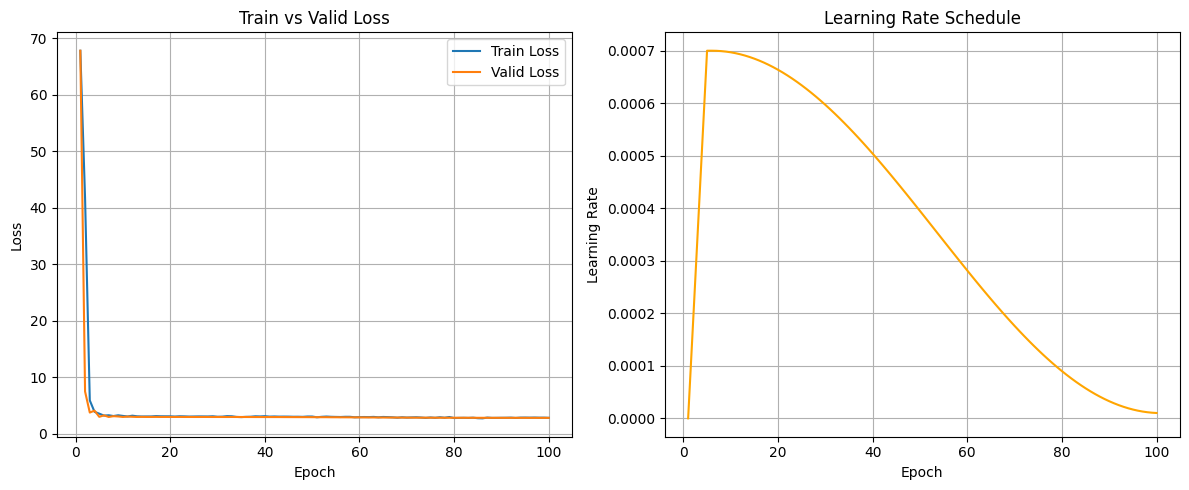

In [ ]:
# Train/Validation loss 및 learning rate 시각화
plot_training_curves(train_losses, valid_losses, learning_rates)

### Test

In [218]:
test = pd.read_csv("C:/Users/user/Desktop/dacon_drug_development/dataset/test.csv")

In [ ]:
# test dataset preprocessing
test['Fingerprint'] = test['Smiles'].apply(smiles_to_fingerprint)
test = test[test['Fingerprint'].notnull()]

test_features_df = pd.DataFrame([descriptors(s) for s in test['Smiles']])
test_final_dataset = pd.concat([test, test_features_df], axis=1)

[13:55:06] DEPRECATION WARNING: please use MorganGenerator
[13:55:06] DEPRECATION WARNING: please use MorganGenerator
[13:55:06] DEPRECATION WARNING: please use MorganGenerator
[13:55:06] DEPRECATION WARNING: please use MorganGenerator
[13:55:06] DEPRECATION WARNING: please use MorganGenerator
[13:55:06] DEPRECATION WARNING: please use MorganGenerator
[13:55:06] DEPRECATION WARNING: please use MorganGenerator
[13:55:06] DEPRECATION WARNING: please use MorganGenerator
[13:55:06] DEPRECATION WARNING: please use MorganGenerator
[13:55:06] DEPRECATION WARNING: please use MorganGenerator
[13:55:06] DEPRECATION WARNING: please use MorganGenerator
[13:55:06] DEPRECATION WARNING: please use MorganGenerator
[13:55:06] DEPRECATION WARNING: please use MorganGenerator
[13:55:06] DEPRECATION WARNING: please use MorganGenerator
[13:55:06] DEPRECATION WARNING: please use MorganGenerator
[13:55:06] DEPRECATION WARNING: please use MorganGenerator
[13:55:06] DEPRECATION WARNING: please use MorganGenerat

In [ ]:
# Data loading for test dataset
test_dataset = test_final_dataset.drop(['ID', 'Smiles'], axis=1)
test = CustomDataset(df=test_dataset, target=None, transform=transform, is_test=True)
test_loader = DataLoader(dataset=test, batch_size=CFG_model['BATCH_SIZE'], shuffle=False)

In [224]:
def inference(test_loader, model):
    model.eval()
    preds = []
    
    with torch.no_grad():
        for inputs in test_loader:
            output = model(inputs)
            preds.extend(output.cpu().numpy().flatten().tolist())
    
    return preds

In [225]:
predictions = inference(test_loader, model_train)

### Submission

In [ ]:
submission = pd.read_csv('C:/Users/user/Desktop/dacon_drug_development/sample_submission.csv')

,ID,ASK1_IC50_nM
0,TEST_000,1
1,TEST_001,2
2,TEST_002,1
3,TEST_003,2
4,TEST_004,1
...,...,...
122,TEST_122,1
123,TEST_123,2
124,TEST_124,1
125,TEST_125,2


In [228]:
submission['ASK1_IC50_nM'] = predictions
submission

,ID,ASK1_IC50_nM
0,TEST_000,7.710835
1,TEST_001,7.980327
2,TEST_002,7.980327
3,TEST_003,8.653662
4,TEST_004,7.959964
...,...,...
122,TEST_122,7.586077
123,TEST_123,7.800220
124,TEST_124,7.695106
125,TEST_125,8.091883


In [230]:
submission.to_csv('C:/Users/user/Desktop/dacon_drug_development/MLP_1_submission.csv', index=False)